# CNN Architectures (LeNet, AlexNet, VGGNet) 
Tutorial reference, further reading and practice: Dive into Deep Learning (https://d2l.ai/)

For this tutorial, we'll use some inbuilt functions of the book. To do so, install the following using your Anaconda command prompt.

In [1]:
# -U: Upgrade all packages to the newest available version
#pip install -U d2l

# Fasion MNIST Image Classification Dataset
One of the widely used dataset for image classification is the MNIST dataset [LeCun et al., 1998]. While it had a good run as a benchmark dataset, even simple models by today’s standards achieve classification accuracy over 95%, making it unsuitable for distinguishing between stronger models and weaker ones. Today, MNIST serves as more of sanity checks than as a benchmark. To up the ante just a bit, we will focus our discussion in the coming sections on the qualitatively similar, but comparatively complex Fashion-MNIST dataset [Xiao et al., 2017], which was released in 2017.

In [2]:
%matplotlib inline
import tensorflow as tf
from d2l import tensorflow as d2l

d2l.use_svg_display()

# Reading the Dataset
We can download and read the Fashion-MNIST dataset into memory via the build-in functions in the framework.

In [3]:
mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()

Fashion-MNIST consists of images from 10 categories, each represented by 6000 images in the training dataset and by 1000 in the test dataset. A test dataset (or test set) is used for evaluating model performance and not for training. Consequently the training set and the test set contain 60000 and 10000 images, respectively.

In [4]:
len(mnist_train[0]), len(mnist_test[0])

(60000, 10000)

The height and width of each input image are both 28 pixels. Note that the dataset consists of grayscale images, whose number of channels is 1. For brevity, throughout this book we store the shape of any image with height $h$ width $w$ pixels as $h\times w$ or ($h$,$w$).

In [5]:
mnist_train[0][0].shape

(28, 28)

The images in Fashion-MNIST are associated with the following categories: t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot. The following function converts between numeric label indices and their names in text.

In [6]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are the images and their corresponding labels (in text) for the first few examples in the training dataset.

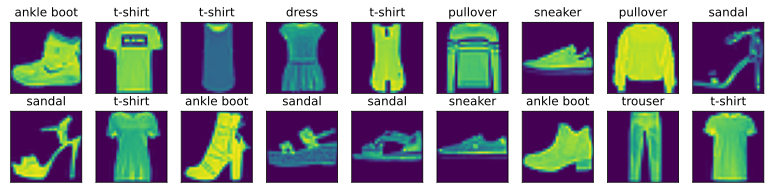

In [8]:
X = tf.constant(mnist_train[0][:18])
y = tf.constant(mnist_train[1][:18])
show_images(X, 2, 9, titles=get_fashion_mnist_labels(y));

# Reading a mini batch
To make our life easier when reading from the training and test sets, we use the built-in data iterator rather than creating one from scratch. Recall that at each iteration, a data loader reads a minibatch of data with size batch_size each time. We also randomly shuffle the examples for the training data iterator.

In [9]:
batch_size = 256
train_iter = tf.data.Dataset.from_tensor_slices(mnist_train).batch(
    batch_size).shuffle(len(mnist_train[0]))

Let us look at the time it takes to read the training data.

In [10]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'0.23 sec'

# Experiment with various CNN architectures

# 1. LeNet

At a high level, LeNet (LeNet-5) consists of two parts: (i) a convolutional encoder consisting of two convolutional layers; and (ii) a dense block consisting of three fully-connected layers; The architecture is summarized below

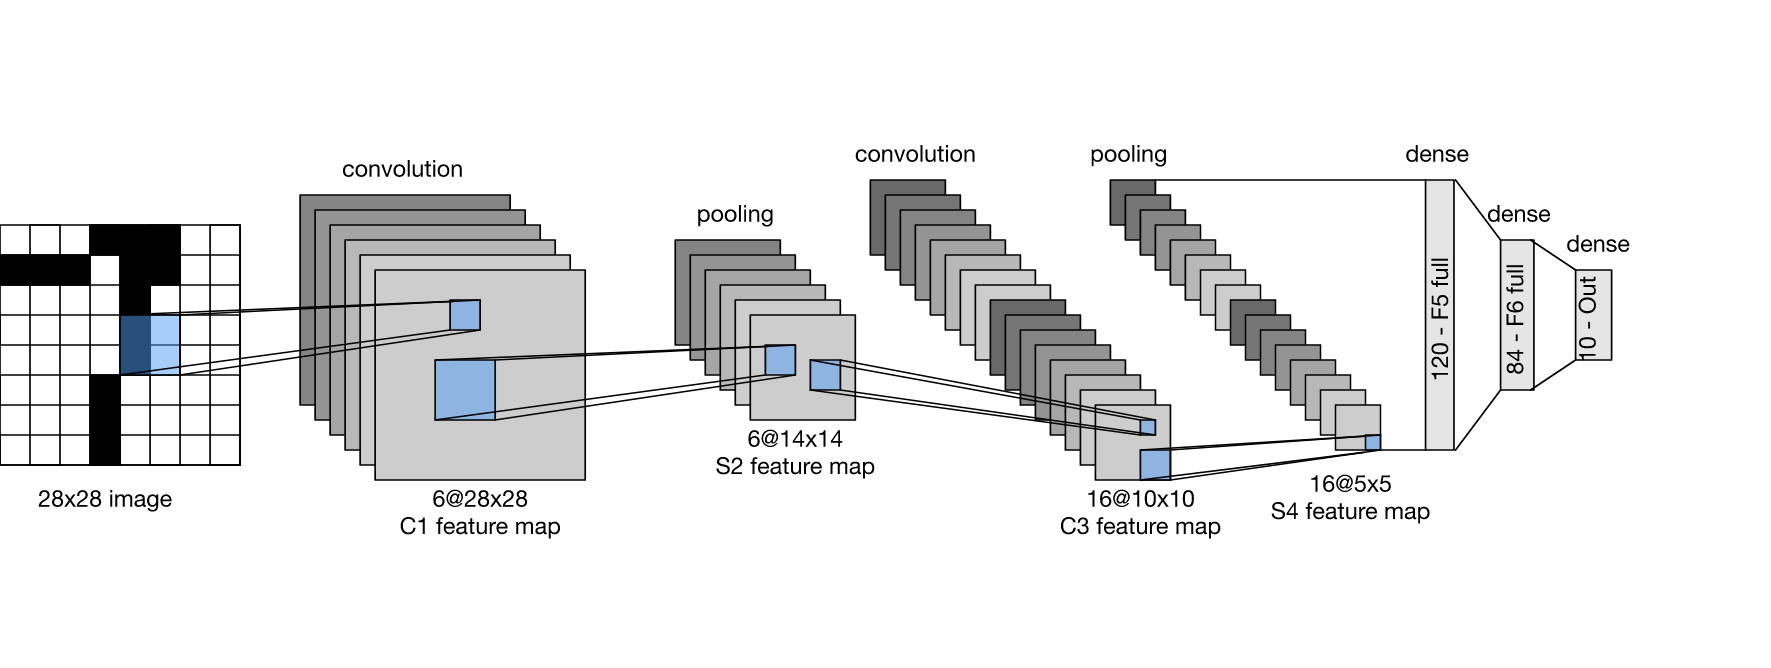

It might take a while to fully understand the underlying code each functions inside LeNet (or any other CNN architectures), it is general practice to take advantages of the modern deep learning frameworks such as Tensoflow / Keras / Pytorch. We need only to instantiate a Sequential block and chain together the appropriate layers.

In [11]:
import tensorflow as tf
from d2l import tensorflow as d2l

def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])

By passing a single-channel (black and white)  28×28  image through the network and printing the output shape at each layer, we can inspect the model to make sure that its operations line up with what we expect from the following figure

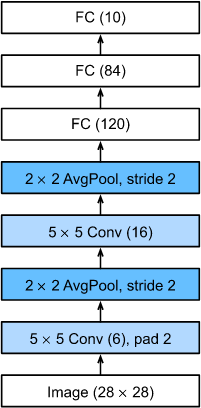

In [12]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (1, 28, 28, 6)
AveragePooling2D output shape: 	 (1, 14, 14, 6)
Conv2D output shape: 	 (1, 10, 10, 16)
AveragePooling2D output shape: 	 (1, 5, 5, 16)
Flatten output shape: 	 (1, 400)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


# Training
Now that we have implemented the model, let us run an experiment to see how LeNet fares on Fashion-MNIST.

In [13]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Since we will be implementing networks with many layers going forward, we will rely primarily on high-level APIs. The following training function assumes a model created from high-level APIs as input and is optimized accordingly. We initialize the model parameters on the device indicated by the device argument, using Xavier initialization https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#subsec-xavier (the chapter is also useful to read generally about various initialisations in MLPs). Just as with MLPs (and in the previous lab), our loss function is cross-entropy, and we minimize it via minibatch stochastic gradient descent. Since each epoch takes tens of seconds to run, we visualize the training loss more frequently.

In [14]:
class TrainCallback(tf.keras.callbacks.Callback):  #@save
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs],
            legend=['train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()

    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(self.test_iter, verbose=0,
                                     return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

#@save
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

Now let us train and evaluate the LeNet-5 model.

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


loss 0.475, train acc 0.821, test acc 0.823
4129.9 examples/sec on /CPU:0


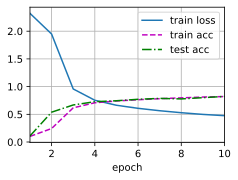

In [17]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 2. AlexNet
For this practical the training will take longer time - may be hours depending on your computer hardware. GPU access will speed up the process. It is recommended you use Google colab https://colab.research.google.com/ 

If you are using Google Colab run the following code first:

In [16]:
#!pip install d2l==0.16.2 # Uncomment and run this if you are using Google Colab

# Learning Representations
In the traditional computer vision algorithms, the most important part of the pipeline was the representation. In deep learning the architecture itself learns the features. Interestingly in the lowest layers of the network, the model learned feature extractors that resembled some traditional filters. AlexNet [Krizhevsky et al., 2012] infact learns and describes lower-level image descriptors which resembles features that are extracted through traditional filters in the usual computer vision pipeline.

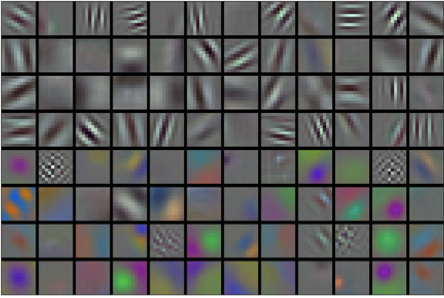

The design philosophies of AlexNet and LeNet are very similar, but there are also significant differences. First, AlexNet is much deeper than the comparatively small LeNet5. AlexNet consists of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer. Second, AlexNet used the ReLU instead of the sigmoid as its activation function.

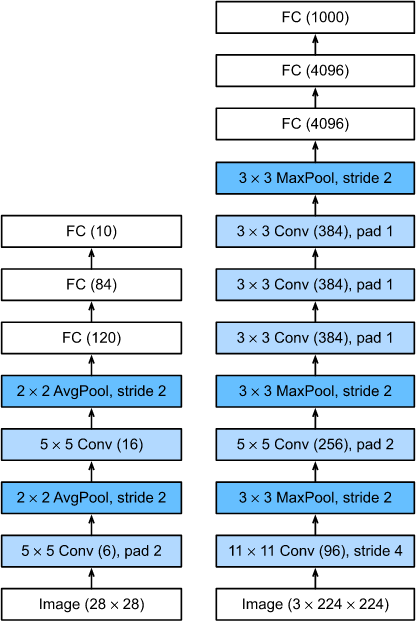

In [17]:
import tensorflow as tf
from d2l import tensorflow as d2l

def net():
    return tf.keras.models.Sequential([
        # Here, we use a larger 11 x 11 window to capture objects. At the same
        # time, we use a stride of 4 to greatly reduce the height and width of
        # the output. Here, the number of output channels is much larger than
        # that in LeNet
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent
        # height and width across the input and output, and increase the
        # number of output channels
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution
        # window. Except for the final convolutional layer, the number of
        # output channels is further increased. Pooling layers are not used to
        # reduce the height and width of input after the first two
        # convolutional layers
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        # Here, the number of outputs of the fully-connected layer is several
        # times larger than that in LeNet. Use the dropout layer to mitigate
        # overfitting
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of
        # classes is 10, instead of 1000 as in the paper
        tf.keras.layers.Dense(10)])

We construct a single-channel data example with both height and width of 224 to observe the output shape of each layer. 

In [18]:
X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Conv2D output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 256)
MaxPooling2D output shape:	 (1, 5, 5, 256)
Flatten output shape:	 (1, 6400)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


# Reading the dataset
Although AlexNet is trained on ImageNet in the paper, we use Fashion-MNIST here since training an ImageNet model to convergence could take hours or days even on a modern GPU. One of the problems with applying AlexNet directly on Fashion-MNIST is that its images have lower resolution ($28\times28$ pixels) than ImageNet images. To make things work, we upsample them to  $224\times224$ (generally not a smart practice, but we do it here to be faithful to the AlexNet architecture). We perform this resizing with the resize argument in the d2l.load_data_fashion_mnist function.

In [19]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

# Training and Evaluation
Now, we can start training AlexNet. Compared with LeNet, the main change here is the use of a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution, and the more costly convolutions.

loss 0.329, train acc 0.880, test acc 0.883
13.9 examples/sec on /CPU:0


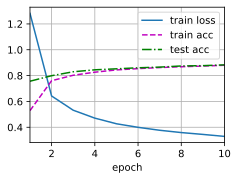

In [20]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# Summary
1. AlexNet has a similar structure to that of LeNet, but uses more convolutional layers and a larger parameter space to fit the large-scale ImageNet dataset.

2. Today AlexNet has been surpassed by much more effective architectures but it is a key step from shallow to deep networks that are used nowadays.

3. Although it seems that there are only a few more lines in AlexNet’s implementation than in LeNet, it took the academic community many years to embrace this conceptual change and take advantage of its excellent experimental results. This was also due to the lack of efficient computational tools.

4. Dropout, ReLU, and preprocessing were the other key steps in achieving excellent performance in computer vision tasks.

# VGGNet
VGGNet will take even longer than AlexNet as the depth of the network increases and size of the filters are larger.

The basic building block of classic CNNs is a sequence of the following: (i) a convolutional layer with padding to maintain the resolution, (ii) a nonlinearity such as a ReLU, (iii) a pooling layer such as a max pooling layer. One VGG block consists of a sequence of convolutional layers, followed by a max pooling layer for spatial downsampling. In the original VGG paper [Simonyan & Zisserman, 2014], the authors employed convolutions with  $3\times3$  kernels with padding of 1 (keeping height and width) and  $2\times2$  max pooling with stride of 2 (halving the resolution after each block). In the code below, we define a function called vgg_block to implement one VGG block.

In [21]:
import tensorflow as tf
from d2l import tensorflow as d2l

def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                   padding='same', activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

Like AlexNet and LeNet, the VGG Network can be partitioned into two parts: the first consisting mostly of convolutional and pooling layers and the second consisting of fully-connected layers. 

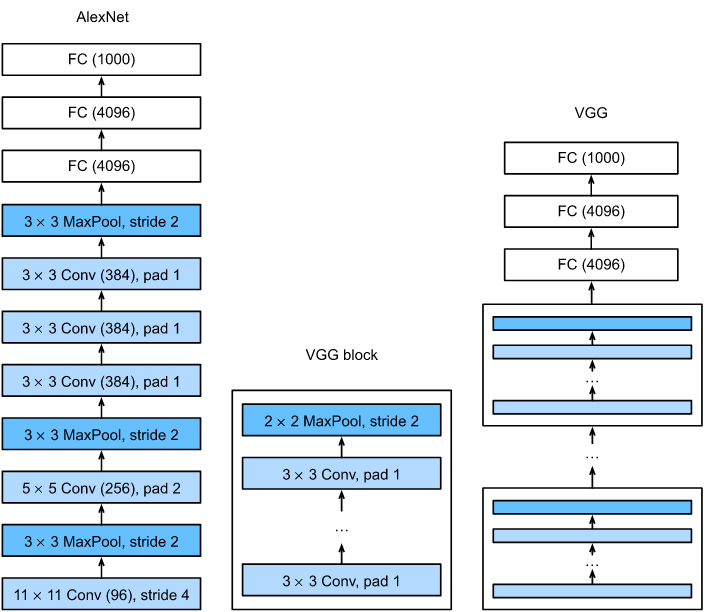

The convolutional part of the network connects several VGG blocks (also defined in the _vgg_block_ function) in succession. The following variable conv_arch consists of a list of tuples (one per block), where each contains two values: the number of convolutional layers and the number of output channels, which are precisely the arguments required to call the vgg_block function. The fully-connected part of the VGG network is identical to that covered in AlexNet.

In [22]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

The following code implements VGG-11. This is a simple matter of executing a for-loop over conv_arch.

In [23]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(
        tf.keras.models.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

Next, we will construct a single-channel data example with a height and width of 224 to observe the output shape of each layer.

In [24]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


# Training and Evaluation
Since VGG-11 is more computationally-heavy than AlexNet we construct a network with a smaller number of channels. This is more than sufficient for training on Fashion-MNIST.

In [25]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
# Recall that this has to be a function that will be passed to
# `d2l.train_ch6()` so that model building/compiling need to be within
# `strategy.scope()` in order to utilize the CPU/GPU devices that we have
net = lambda: vgg(small_conv_arch)

Apart from using a slightly larger learning rate, the model training process is similar to that of AlexNet

KeyboardInterrupt: 

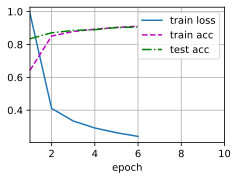

In [26]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())